# Задание 3 - MRR

In [ ]:
import time
import timeit

import numba as nb
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
%cd "/content/drive/MyDrive/Lesson_2/kion_train"

/content/drive/.shortcut-targets-by-id/1xmF53GhoQ30wUv59xuyQ7PqgoLF1O4af/Lesson_2/kion_train


In [5]:
np.random.seed(23)

In [6]:
interactions = pd.read_csv("interactions.csv")

interactions.rename(
    columns={"track_id": "item_id", "last_watch_dt": "datetime", "total_dur": "weight"},
    inplace=True,
)

interactions["datetime"] = pd.to_datetime(interactions["datetime"])

In [7]:
users = pd.read_csv("users.csv")
items = pd.read_csv("items.csv")

In [8]:
def headtail(df):
    return pd.concat([df.head(), df.tail()])


headtail(interactions)

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [9]:
interactions.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int64         
 1   item_id      int64         
 2   datetime     datetime64[ns]
 3   weight       int64         
 4   watched_pct  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


Генерация выборки

In [10]:
def generate_subsample(users_count, top_k, data=interactions):
    users = np.random.choice(data["user_id"].unique(), users_count, replace=False)
    df = data[data["user_id"].isin(users)].reset_index(drop=True)
    del df["datetime"], df["weight"], df["watched_pct"]

    recs = np.random.choice(df["item_id"], size=(users_count, top_k))
    return df, users, recs

## MRR

Naive

In [11]:
def mrr_naive(target, users, recs):
    mrr = []
    for i, user in enumerate(users):
        user_mrr = 0.0
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                user_mrr = 1 / (j + 1)
                break
        mrr.append(user_mrr)
    return sum(mrr) / len(users)

Numba

In [12]:
@nb.njit(cache=True, parallel=True)
def mrr_numba(target, users, recs):
    mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user_mrr = 0.0
        user = users[i]
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                user_mrr = 1 / (j + 1)
                break
        mrr[i] = user_mrr
    return mrr.mean()

Pandas

In [13]:
def mrr_pandas(df_target, users, recs):
    k = recs.shape[1]
    df_recs = pd.DataFrame({"user_id": np.repeat(users, k), "item_id": recs.ravel()})
    df_recs["rank"] = df_recs.groupby("user_id").cumcount() + 1
    df_target["target"] = 1
    df_recs = df_recs.merge(
        df_target,
        how="left",
        left_on=["user_id", "item_id"],
        right_on=["user_id", "item_id"],
    )
    df_target.drop(["target"], axis=1, inplace=True)
    df_recs["reciprocal_rank"] = 0
    df_recs.loc[~df_recs["target"].isna(), "reciprocal_rank"] = 1 / (
        df_recs.loc[~df_recs["target"].isna(), "rank"]
    )
    mrr = df_recs.groupby("user_id")["reciprocal_rank"].max().sum() / len(users)
    return mrr

Протестируем для всех комбинаций (users_count, top_k):
* users_count - [100, 1000, 5000, 10000]
* top_k - [10, 50, 100]

In [22]:
users_counts = [100, 1000, 5000, 10000]
top_k = [10, 50, 100]

In [18]:
def check_values():
    for i in users_counts:
        for j in top_k:
            for _ in range(10):
                df, users, recs = generate_subsample(i, j)
                target = df.values
                naive_mrr = mrr_naive(target, users, recs)
                nb_mrr = mrr_numba(target, users, recs)
                pd_mrr = mrr_pandas(df, users, recs)

                assert np.abs(naive_mrr - nb_mrr) < 1e-4
                assert np.abs(naive_mrr - pd_mrr) < 1e-4
                assert np.abs(nb_mrr - pd_mrr) < 1e-4

    return "Metrics are similar in meaning"

In [23]:
check_values()

'Metrics are similar in meaning'

Сравнительный анализ

In [45]:
users_counts_new = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]
n_runs = 10

In [46]:
avg_time_naive = np.zeros((len(users_counts_new), len(top_k)))
avg_time_numba = np.zeros((len(users_counts_new), len(top_k)))
avg_time_pandas = np.zeros((len(users_counts_new), len(top_k)))

In [48]:
for i, user_count in enumerate(users_counts):
    for j, top in enumerate(top_k):
        df, users, recs = generate_subsample(user_count, top)
        target = df.values

        print(f"Run naive user_count: {user_count}, top_k: {top} for {n_runs} times")
        t = timeit.timeit(
            "mrr_naive(target, users, recs)",
            "from __main__ import mrr_naive, target, users, recs",
            number=n_runs,
        )
        print(f"Avg time: {t / n_runs:0.4f} seconds")
        avg_time_naive[i][j] = t / n_runs

Run naive user_count: 100, top_k: 10 for 10 times
Avg time: 0.0038 seconds
Run naive user_count: 100, top_k: 50 for 10 times
Avg time: 0.0096 seconds
Run naive user_count: 100, top_k: 100 for 10 times
Avg time: 0.0166 seconds
Run naive user_count: 1000, top_k: 10 for 10 times
Avg time: 0.0487 seconds
Run naive user_count: 1000, top_k: 50 for 10 times
Avg time: 0.1247 seconds
Run naive user_count: 1000, top_k: 100 for 10 times
Avg time: 0.1800 seconds
Run naive user_count: 5000, top_k: 10 for 10 times
Avg time: 0.4801 seconds
Run naive user_count: 5000, top_k: 50 for 10 times
Avg time: 0.8528 seconds
Run naive user_count: 5000, top_k: 100 for 10 times
Avg time: 1.1701 seconds
Run naive user_count: 10000, top_k: 10 for 10 times
Avg time: 1.6509 seconds
Run naive user_count: 10000, top_k: 50 for 10 times
Avg time: 2.4539 seconds
Run naive user_count: 10000, top_k: 100 for 10 times
Avg time: 3.0044 seconds


In [49]:
for i, user_count in enumerate(users_counts):
    for j, top in enumerate(top_k):
        df, users, recs = generate_subsample(user_count, top)
        target = df.values

        print(f"Run numba user_count: {user_count}, top_k: {top} for {n_runs} times")
        t = timeit.timeit(
            "mrr_numba(target, users, recs)",
            "from __main__ import mrr_numba, target, users, recs",
            number=n_runs,
        )
        print(f"Avg time: {t / n_runs:0.4f} seconds")
        avg_time_numba[i][j] = t / n_runs

Run numba user_count: 100, top_k: 10 for 10 times
Avg time: 0.0002 seconds
Run numba user_count: 100, top_k: 50 for 10 times
Avg time: 0.0002 seconds
Run numba user_count: 100, top_k: 100 for 10 times
Avg time: 0.0002 seconds
Run numba user_count: 1000, top_k: 10 for 10 times
Avg time: 0.0105 seconds
Run numba user_count: 1000, top_k: 50 for 10 times
Avg time: 0.0107 seconds
Run numba user_count: 1000, top_k: 100 for 10 times
Avg time: 0.0100 seconds
Run numba user_count: 5000, top_k: 10 for 10 times
Avg time: 0.2515 seconds
Run numba user_count: 5000, top_k: 50 for 10 times
Avg time: 0.2601 seconds
Run numba user_count: 5000, top_k: 100 for 10 times
Avg time: 0.2588 seconds
Run numba user_count: 10000, top_k: 10 for 10 times
Avg time: 1.0063 seconds
Run numba user_count: 10000, top_k: 50 for 10 times
Avg time: 1.0114 seconds
Run numba user_count: 10000, top_k: 100 for 10 times
Avg time: 0.9732 seconds


In [50]:
for i, user_count in enumerate(users_counts):
    for j, top in enumerate(top_k):
        df, users, recs = generate_subsample(user_count, top)
        target = df.values

        print(f"Run pandas user_count: {user_count}, top_k: {top} for {n_runs} times")
        t = timeit.timeit(
            "mrr_pandas(df, users, recs)",
            "from __main__ import mrr_pandas, df, users, recs",
            number=n_runs,
        )
        print(f"Avg time: {t / n_runs:0.4f} seconds")
        avg_time_pandas[i][j] = t / n_runs

Run pandas user_count: 100, top_k: 10 for 10 times
Avg time: 0.0065 seconds
Run pandas user_count: 100, top_k: 50 for 10 times
Avg time: 0.0079 seconds
Run pandas user_count: 100, top_k: 100 for 10 times
Avg time: 0.0086 seconds
Run pandas user_count: 1000, top_k: 10 for 10 times
Avg time: 0.0088 seconds
Run pandas user_count: 1000, top_k: 50 for 10 times
Avg time: 0.0183 seconds
Run pandas user_count: 1000, top_k: 100 for 10 times
Avg time: 0.0268 seconds
Run pandas user_count: 5000, top_k: 10 for 10 times
Avg time: 0.0221 seconds
Run pandas user_count: 5000, top_k: 50 for 10 times
Avg time: 0.0694 seconds
Run pandas user_count: 5000, top_k: 100 for 10 times
Avg time: 0.1306 seconds
Run pandas user_count: 10000, top_k: 10 for 10 times
Avg time: 0.0404 seconds
Run pandas user_count: 10000, top_k: 50 for 10 times
Avg time: 0.1355 seconds
Run pandas user_count: 10000, top_k: 100 for 10 times
Avg time: 0.2785 seconds


Видно, что алгоритм через pandas работает быстрее чем naive и numba.

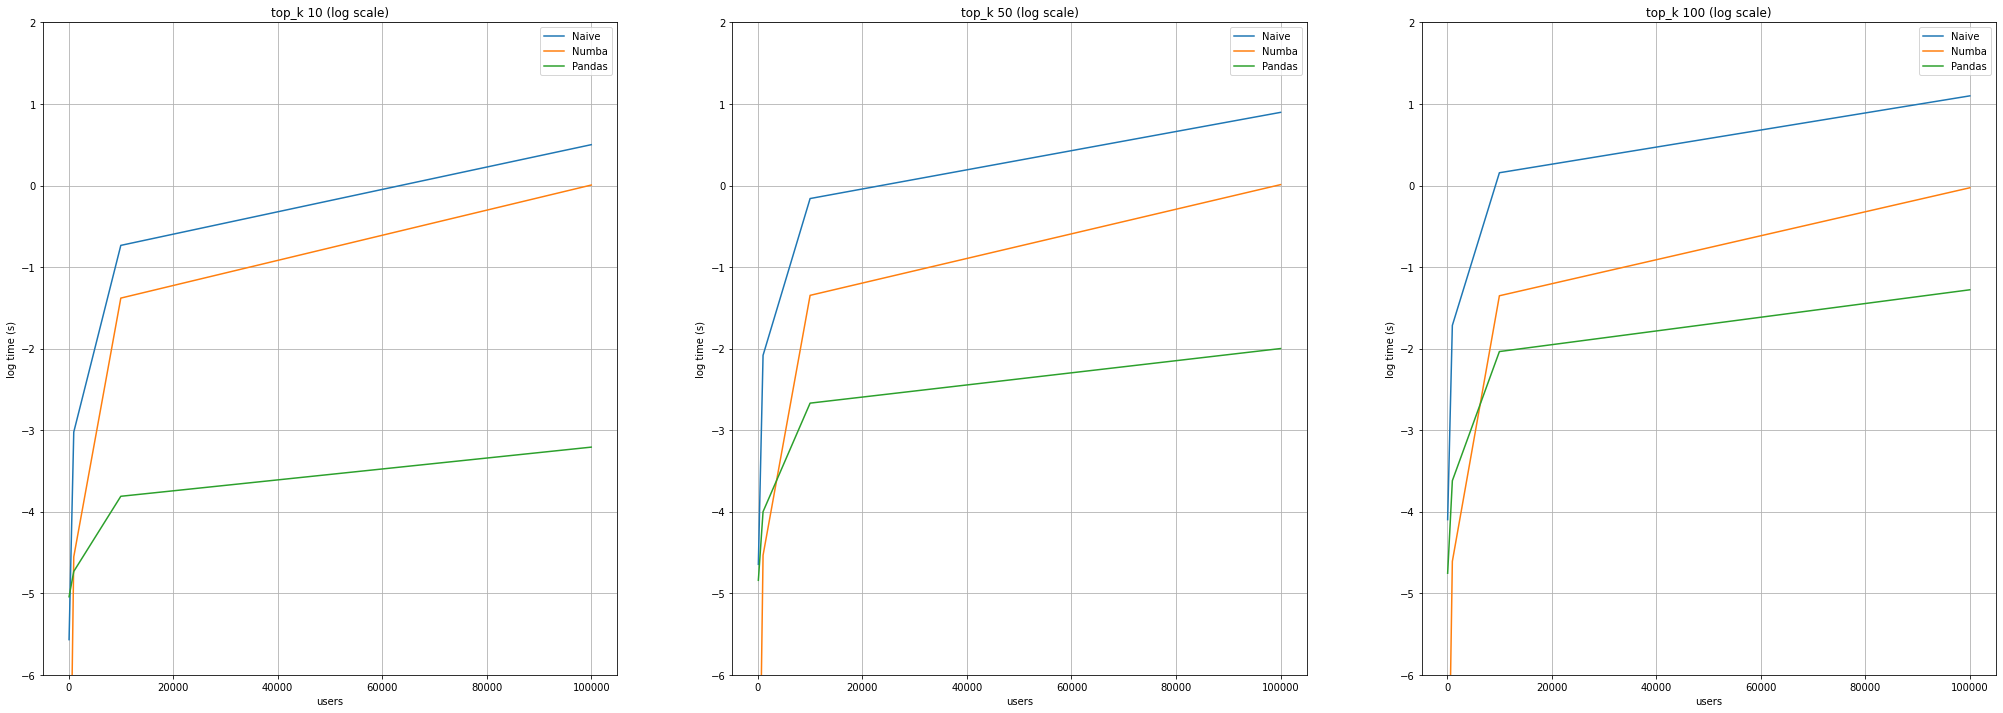

In [75]:
_, ax = plt.subplots(1, 3, figsize=(35, 12))
for i in range(3):

    ax[i].plot(users_counts_new, np.log(avg_time_naive[:, i]), label="Naive")
    ax[i].plot(users_counts_new, np.log(avg_time_numba[:, i]), label="Numba")
    ax[i].plot(users_counts_new, np.log(avg_time_pandas[:, i]), label="Pandas")
    ax[i].set_title(f"top_k {top_k[i]} (log scale)")
    ax[i].set_xlabel("users")
    ax[i].set_ylabel("log time (s)")
    ax[i].set_ylim(-6, 2)
    ax[i].grid()
    ax[i].legend()
plt.show()

Аналогично заметно преимущество pandas на графиках.

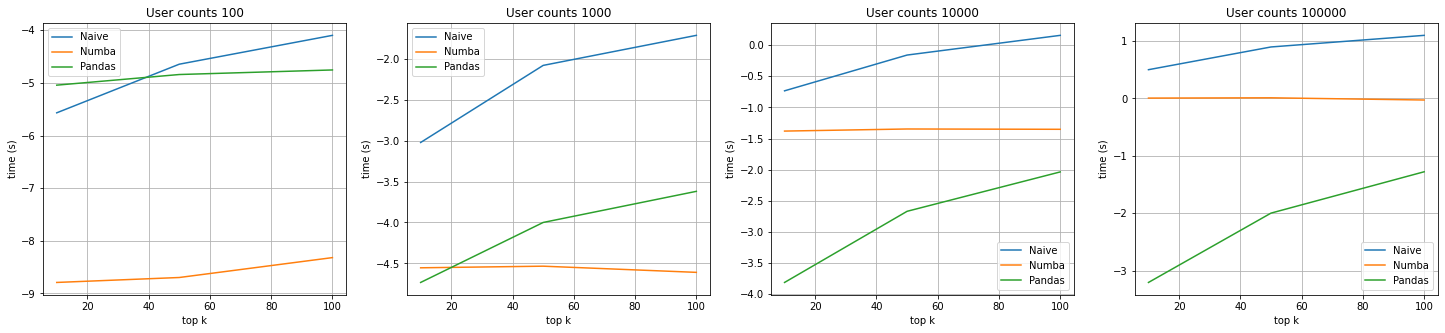

In [77]:
_, ax = plt.subplots(1, 4, figsize=(25, 5))
for i in range(4):
    ax[i].plot(top_k, np.log(avg_time_naive[i, :]), label="Naive")
    ax[i].plot(top_k, np.log(avg_time_numba[i, :]), label="Numba")
    ax[i].plot(top_k, np.log(avg_time_pandas[i, :]), label="Pandas")
    ax[i].set_title(f"User counts {users_counts_new[i]}")
    ax[i].grid()
    ax[i].set_xlabel("top k")
    ax[i].set_ylabel("time (s)")
    ax[i].legend()
plt.show()